In [1]:
import evspy
import evspy.loading_empirical_data as loading_data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import warnings
import FormatFig
%matplotlib inline

/home/thomasvergote/anaconda3/envs/psgis/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [2]:
class cs_model:
    def __init__(self, Cc, Cr, CalphaNC, OCRref_initial,OCRref_final, OCR_final, erateref, sigma0 = 100, sigmap = 100,
                 dimt=100000,dtfactor=1e-7,Cv=5/3600/24/365,H=0.01,targettime=1e10, swelling_isotache = False,
                 nonlinear_Calphahat=True,sigmaref=100,beta2=4.2,beta3=20.5,m_1=0.88, b_1 = -1.43, m_2 = 2.59, b_2 = -5.3, 
                 hypA=False, model_type = 'load_controlled'):
        self.Calphahatc = evspy.beta2_fit(beta2,OCRref_final)*CalphaNC
        self.Calphahats = evspy.power_law(OCR_final,m_1,b_1)*CalphaNC
        self.erateci = evspy.beta3_fit(beta3,OCRref_final)*erateref
        self.eratesi = evspy.power_law(OCR_final,m_2,b_2)
        self.Cc = Cc
        self.Cr = Cr
        self.OCRref_initial = OCRref_initial
        self.OCRref_final = OCRref_final
        self.dimt = dimt
        self.dtfactor = dtfactor
        self.Cv = Cv
        self.H = H
        self.targettime = targettime
        self.nonlinear_Calphahat = nonlinear_Calphahat
        self.sigmaref = sigmaref
        self.beta2 = beta2
        self.beta3 = beta3
        self.hypA = hypA
        self.model_type = model_type
        self.g = 9.81
        self.sigma0 = sigma0
        self.swelling_isotache = swelling_isotache
        self.sigmap = sigmap
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            if model_type == 'load_controlled':
                res = evspy.C_S_model_with_load(self.Calphahatc, self.Calphahats,  self.erateci, self.eratesi, self.Cr,self.Cc, 
                                            self.OCRref_initial,self.OCRref_final,dimt=self.dimt,dtfactor = self.dtfactor,Cv = self.Cv,H = self.H,targettime = self.targettime,
                                                nonlinear_Calphahat = self.nonlinear_Calphahat, sigmaref = self.sigmaref,beta2 = self.beta2,beta3 = self.beta3,hypA = self.hypA)
            elif model_type == 'relaxation':
                res = evspy.C_S_relaxation(self.Calphahatc, self.Calphahats,  self.erateci, self.eratesi, self.Cr,self.Cc,self.sigma0,dimt=self.dimt,dtfactor = self.dtfactor,
                                                 targettime = self.targettime,nonlinear_Calphahat = self.nonlinear_Calphahat, swelling_isotache=self.swelling_isotache,
                                                 OCR = self.OCRref_final, beta2 = self.beta2, beta3 = self.beta3)
            elif model_type == 'rate_controlled':
                res = evspy.C_S_CRS(self.Cc,self.Cr,self.sigmap,self.erateci,self.CalphaNC,erateref = self.erateref, Cc_reduction=2.3,
                                    Cc_f_OCR=False,erates0=-1,erate = 1,sigma0=265,sigmaf=160,b2=b2,m2=m2,beta2=self.beta2,beta3=self.beta3,estart=1,m1=m1,b1=b1,dtfactor=1)
            #### TO BE FINALISED!!!

        self.time = res['time']
        self.e = res['e']
        self.erate = res['erate']
        self.erate_c = res['erate_c']
        self.erate_s = res['erate_s']
        self.Calphahatc = res['Calphahatc']
        if model_type == 'load_controlled':
            self.OCR = res['OCR']
            self.OCR_ref = res['OCR_ref']
            self.erate_e = res['erate_e']
        if model_type == 'relaxation':
            self.sigma = res['sigma']
        


# Preload 20m thick clay layer
- superimposed modelling

In [3]:
H = 20
depth_w = 2
gamman = 16
gammaw = 10
Cc = 0.4
Cr = Cc/10
Cv = 20/365/3600/24
CalphaCc = 0.04
Calpha = Cc*CalphaCc
e0 = 2
tref = 24*3600
tpreload = 6*30*24*3600
preload = 100
beta2 = 4.2
Z = np.arange(0,H+1,1)
sigv_tot = {'init':Z*gamman}
sigv_hyd = {'init':np.clip(Z*gammaw-depth_w*gammaw,0,np.infty)}
sigv_eff = {'init':sigv_tot['init']-sigv_hyd['init']}
erateref = Calpha*(1/(np.log(10)*24*3600))
def calculate_over_depth(preload,tpreload):
    OCRref1 = ((tref+tpreload)/tref)**(Calpha/((tref+tpreload)/tref)**(beta2/4.*CalphaCc)/(Cc-Cr))  #Creep induced OCR; constant over depth
    print(OCRref1)
    OCR = (sigv_eff['init']+preload)/sigv_eff['init']
    OCRref2 = OCRref1*OCR
    model = {}
    time = 10**np.arange(1,np.log10(100*365*24*3600),0.1)
    df=pd.DataFrame(index=time)
    for i in tqdm.tqdm(range(len(OCR))):
        model[i] = cs_model(Cc, Cr, Calpha, OCRref1,OCRref2[i], OCR[i],erateref, H = 1, Cv = Cv)
        df[i] = np.interp(time,model[i].time,model[i].e)
    return df

/home/thomasvergote/anaconda3/envs/psgis/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


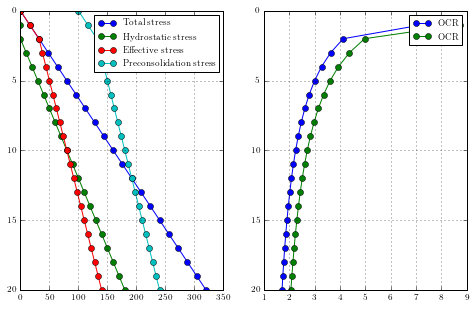

In [5]:
plt.figure(figsize=(8,5))
plt.subplot(121)
plt.plot(sigv_tot['init'],Z,'o-',label='Total stress')
plt.plot(sigv_hyd['init'],Z,'o-',label='Hydrostatic stress')
plt.plot(sigv_eff['init'],Z,'o-',label='Effective stress')
plt.plot(sigv_eff['init']+preload,Z,'o-',label='Preconsolidation stress')
plt.xlim(0); plt.ylim(0,H)
plt.gca().invert_yaxis(); plt.legend(); plt.grid()
plt.subplot(122)
OCRref1 = ((tref+tpreload)/tref)**(Calpha/((tref+tpreload)/tref)**(beta2/4.*CalphaCc)/(Cc-Cr))  #Creep induced OCR; constant over depth
OCR = (sigv_eff['init']+preload)/sigv_eff['init']
OCRref2 = OCRref1*OCR
plt.plot(OCR,Z,'o-',label='OCR')
plt.plot(OCRref2,Z,'o-',label='OCR')
plt.xlim(1); plt.ylim(0,H)
plt.gca().invert_yaxis(); plt.legend(); plt.grid()

In [6]:
model = {}
time = 10**np.arange(1,np.log10(100*365*24*3600),0.1)
df=pd.DataFrame(index=time)
for i in tqdm.tqdm(range(len(OCR))):
    model[i] = cs_model(Cc, Cr, Calpha, OCRref1,OCRref2[i], OCR[i],erateref, H = 1, Cv = Cv)
    df[i] = np.interp(time,model[i].time,model[i].e)


100%|██████████| 21/21 [00:01<00:00, 10.84it/s]


100%|██████████| 19/19 [00:00<00:00, 381.61it/s]


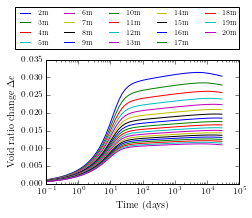

In [68]:
plt.figure(figsize=FormatFig.figsize(0.6,golden_mean=1))
for i in tqdm.tqdm(range(2,len(OCR))):
    plt.semilogx(time/24/3600,-df[i],label=str(Z[i])+'m')
plt.xlim(0.1); plt.ylim(0.); plt.legend(ncol=5,fontsize=7,bbox_to_anchor=(1.02,1.45))
plt.xlabel('Time (days)'); plt.ylabel('Void ratio change $\Delta e$')
plt.tight_layout()
plt.savefig('layered_response.svg')

In [28]:
df1={}
tpreload = 6*30*24*3600
for preload in [20,50,100,200]:
    df1[preload] = calculate_over_depth(preload,tpreload)

/home/thomasvergote/anaconda3/envs/psgis/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
 10%|▉         | 2/21 [00:00<00:01, 17.92it/s]

1.2040923333546762


100%|██████████| 21/21 [00:02<00:00,  9.93it/s]
/home/thomasvergote/anaconda3/envs/psgis/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
 10%|▉         | 2/21 [00:00<00:01, 18.57it/s]

1.2040923333546762


100%|██████████| 21/21 [00:01<00:00, 10.68it/s]
/home/thomasvergote/anaconda3/envs/psgis/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
 10%|▉         | 2/21 [00:00<00:01, 18.04it/s]

1.2040923333546762


100%|██████████| 21/21 [00:01<00:00, 10.87it/s]
/home/thomasvergote/anaconda3/envs/psgis/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
 10%|▉         | 2/21 [00:00<00:01, 15.60it/s]

1.2040923333546762


100%|██████████| 21/21 [00:02<00:00,  9.80it/s]


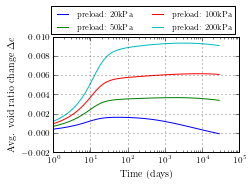

In [60]:
plt.figure(figsize=FormatFig.figsize(0.6,golden_mean=0.8))
for preload in [20,50,100,200]:
    plt.semilogx(time/24/3600,-df1[preload].mean(axis=1)/(1+e0)*1,label='preload: '+str(preload)+'kPa')
plt.xlim(1); plt.grid();plt.legend(fontsize=8,bbox_to_anchor=(1,1.3),ncol=2); #plt.ylim(-0.05,0.25)
plt.xlabel('Time (days)'); plt.ylabel('Avg. void ratio change $\Delta e$')
plt.tight_layout()
plt.savefig('sensitivity_preload.svg')

In [10]:
preload = 50
df2={}
for tpreload in [1,6,12,24]:
    tpreload = tpreload*30*24*3600
    df2[tpreload] = calculate_over_depth(preload,tpreload)

/home/thomasvergote/anaconda3/envs/psgis/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
 10%|▉         | 2/21 [00:00<00:01, 14.89it/s]

1.141248870688575


100%|██████████| 21/21 [00:02<00:00,  8.64it/s]
/home/thomasvergote/anaconda3/envs/psgis/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
 10%|▉         | 2/21 [00:00<00:01, 15.90it/s]

1.2040923333546762


100%|██████████| 21/21 [00:02<00:00,  9.19it/s]
/home/thomasvergote/anaconda3/envs/psgis/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
 10%|▉         | 2/21 [00:00<00:01, 15.88it/s]

1.2267621215489057


100%|██████████| 21/21 [00:02<00:00,  9.22it/s]
/home/thomasvergote/anaconda3/envs/psgis/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
 10%|▉         | 2/21 [00:00<00:01, 14.64it/s]

1.2483795426361861


100%|██████████| 21/21 [00:02<00:00,  9.59it/s]


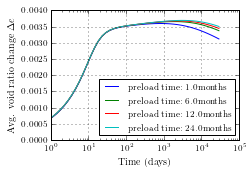

In [63]:
plt.figure(figsize=FormatFig.figsize(0.6,golden_mean=0.7))
for tpreload in [1,6,12,24]:
    tpreload = tpreload*30*24*3600
    plt.semilogx(time/24/3600,-df2[tpreload].mean(axis=1)/(1+e0)*1,label='preload time: '+str(tpreload/30/24/3600)+'months')
plt.xlim(1); plt.grid();plt.legend(loc=4); 
plt.xlabel('Time (days)'); plt.ylabel('Avg. void ratio change $\Delta e$')
plt.tight_layout()
plt.savefig('sensitivity_preload_time.svg')